In [ ]:
from pyspark.sql import SparkSession

# Initialize Spark session with increased memory and network buffer size
spark = SparkSession.builder \
    .appName("FinalProject") \
    .master("local[*]") \
    .config("spark.driver.memory", "4g") \
    .config("spark.executor.memory", "4g") \
    .config("spark.driver.host", "127.0.0.1") \
    .config("spark.driver.bindAddress", "127.0.0.1") \
    .config("spark.network.timeout", "600s") \
    .config("spark.executor.heartbeatInterval", "100s") \
    .config("spark.shuffle.file.buffer", "1m") \
    .config("spark.reducer.maxSizeInFlight", "96m") \
    .getOrCreate()

In [ ]:
print(spark.sparkContext)

<SparkContext master=local[*, 4] appName=Databricks Shell>


In [ ]:
spark

In [ ]:
# Set the storage account access key
spark.conf.set("spark.hadoop.fs.azure.account.key._username_.blob.core.windows.net", "_key_")

In [ ]:
# Load data from the CSV file
df = spark.read.csv("wasbs://_username_and_containername.blob.core.windows.net/final_dataset_twitter.csv", header=True, inferSchema=True)

In [ ]:
df.show()

+---+------+--------------------+
|_c0|target|                text|
+---+------+--------------------+
|  0|     0|@switchfoot http:...|
|  1|     0|is upset that he ...|
|  2|     0|@Kenichan I dived...|
|  3|     0|my whole body fee...|
|  4|     0|@nationwideclass ...|
|  5|     0|@Kwesidei not the...|
|  6|     0|         Need a hug |
|  7|     0|@LOLTrish hey  lo...|
|  8|     0|@Tatiana_K nope t...|
|  9|     0|@twittera que me ...|
| 10|     0|spring break in p...|
| 11|     0|I just re-pierced...|
| 12|     0|@caregiving I cou...|
| 13|     0|@octolinz16 It it...|
| 14|     0|@smarrison i woul...|
| 15|     0|@iamjazzyfizzle I...|
| 16|     0|Hollis' death sce...|
| 17|     0|about to file taxes |
| 18|     0|@LettyA ahh ive a...|
| 19|     0|@FakerPattyPattz ...|
+---+------+--------------------+
only showing top 20 rows



In [ ]:
df = df.drop("_c0")

In [ ]:
df.printSchema()

root
 |-- target: integer (nullable = true)
 |-- text: string (nullable = true)



In [ ]:
df.show()

+------+--------------------+
|target|                text|
+------+--------------------+
|     0|@switchfoot http:...|
|     0|is upset that he ...|
|     0|@Kenichan I dived...|
|     0|my whole body fee...|
|     0|@nationwideclass ...|
|     0|@Kwesidei not the...|
|     0|         Need a hug |
|     0|@LOLTrish hey  lo...|
|     0|@Tatiana_K nope t...|
|     0|@twittera que me ...|
|     0|spring break in p...|
|     0|I just re-pierced...|
|     0|@caregiving I cou...|
|     0|@octolinz16 It it...|
|     0|@smarrison i woul...|
|     0|@iamjazzyfizzle I...|
|     0|Hollis' death sce...|
|     0|about to file taxes |
|     0|@LettyA ahh ive a...|
|     0|@FakerPattyPattz ...|
+------+--------------------+
only showing top 20 rows



In [ ]:
from pyspark.sql.functions import col, count

# Group by the "text" column, count occurrences, and filter duplicates
duplicate_cleaned_rows = df.groupBy("text") \
                           .agg(count("*").alias("count")) \
                           .filter(col("count") > 1) \
                           .orderBy(col("count").desc())

# Show the duplicate rows ordered by count
duplicate_cleaned_rows.show(truncate=False)

+-------------------------------------------------------------------------------------------------------+-----+
|text                                                                                                   |count|
+-------------------------------------------------------------------------------------------------------+-----+
|isPlayer Has Died! Sorry                                                                               |210  |
|good morning                                                                                           |118  |
|headache                                                                                               |115  |
|Good morning                                                                                           |112  |
|Headache                                                                                               |106  |
| cant afford to see Angels and Demons, so i watched it for free: http://tr.im/lvBu                     

In [ ]:
# Drop duplicate rows based on the "text" column
distinct_df = df.dropDuplicates(["text"])

# Step 2: Check for remaining duplicates
remaining_duplicates = distinct_df.groupBy("text") \
                                       .agg(count("*").alias("count")) \
                                       .filter(col("count") > 1)

# Check the count of remaining duplicates
remaining_duplicates.count()

0

In [ ]:
# Split the new DataFrame into training and testing sets
train_df, test_df = distinct_df.randomSplit([0.75, 0.25], seed=1234)

In [ ]:
# Show the counts to ensure the split worked correctly
print(f"Total rows in training DataFrame: {train_df.count()}")
print(f"Total rows in testing DataFrame: {test_df.count()}")

Total rows in training DataFrame: 1186100
Total rows in testing DataFrame: 395366


# text cleaning on training

In [ ]:
from pyspark.ml.feature import RegexTokenizer, StopWordsRemover, CountVectorizer
from pyspark.sql.functions import col, udf, lower, regexp_replace
from pyspark.sql.types import StringType

In [ ]:
def clean_text(df, column_name):
    df = df.withColumn(column_name, regexp_replace(col(column_name), r"http\S+", ""))  # Remove URLs
    df = df.withColumn(column_name, regexp_replace(col(column_name), r"@\w+", ""))     # Remove mentions
    df = df.withColumn(column_name, regexp_replace(col(column_name), r"[^a-zA-Z\s]", ""))  # Remove non-alphabetic characters
    df = df.withColumn(column_name, lower(col(column_name)))  # Convert to lowercase
    return df

In [ ]:
train_cleaned_df = clean_text(train_df, "text")

In [ ]:
train_cleaned_df.show()

+------+--------------------+
|target|                text|
+------+--------------------+
|     0|      i must thin...|
|     0|     ill get on i...|
|     0|    lt this is th...|
|     0|    i miss my sum...|
|     0|   awwwwwh  i wan...|
|     0|   boston globe c...|
|     0|   from gongwer o...|
|     0|   im sick of bed...|
|     0|   im thinking of...|
|     0|   j you are righ...|
|     0|   cant be bother...|
|     0|    i dont even know|
|     0|   i still feel l...|
|     0|   i want an octo...|
|     0|   i wish i could...|
|     0|   kinda but not ...|
|     0|      no shopping   |
|     0|    not at all happy|
|     0|   sigh   ok wher...|
|     0|  whats wrong wit it|
+------+--------------------+
only showing top 20 rows



In [ ]:
from pyspark.sql.functions import col, count

# Group by the "cleaned_words" column, count occurrences, and filter duplicates
duplicate_cleaned_rows = train_cleaned_df.groupBy("text") \
                                         .agg(count("*").alias("count")) \
                                         .filter(col("count") > 1) \
                                         .orderBy(col("count").desc())

# Show the duplicate rows ordered by count
duplicate_cleaned_rows.show(truncate=False)

+------------------------------------------------------------------------------------------------------+-----+
|text                                                                                                  |count|
+------------------------------------------------------------------------------------------------------+-----+
|                                                                                                      |1788 |
| thanks                                                                                               |1286 |
| thank you                                                                                            |799  |
| get  followers a day using wwwtweeteraddercom once you add everyone you are on the train or pay vip  |601  |
| get  followers a day using wwwtweeterfollowcom once you add everyone you are on the train or pay vip |489  |
| i am lost please help me find a good home                                                            |405  |
|

In [ ]:
# Drop duplicate rows based on the "text" column
train_cleaned_df = train_cleaned_df.dropDuplicates(["text"])

# Step 2: Check for remaining duplicates
remaining_duplicates = train_cleaned_df.groupBy("text") \
                                       .agg(count("*").alias("count")) \
                                       .filter(col("count") > 1)

# Check the count of remaining duplicates
remaining_duplicates.count()

0

# text cleaning on testing data

In [ ]:
test_cleaned_df = clean_text(test_df, "text")

In [ ]:
test_cleaned_df.show()

+------+--------------------+
|target|                text|
+------+--------------------+
|     0|     lt but musta...|
|     0|    not feeling i...|
|     0|         enough said|
|     0|  another expensi...|
|     0|  anyone in dfw w...|
|     0|  cats in the cra...|
|     0|  exercise  build...|
|     0|  hoegaarden chee...|
|     0|  i am so sad i l...|
|     0|  i dont want my ...|
|     0|  i think manuel ...|
|     0|  to all the moth...|
|     0|  why arent there...|
|     0|    but i understand|
|     0|  forgot my lunch...|
|     0|  friends are lea...|
|     0|  i hate being at...|
|     0|  missing my jenn...|
|     0|  no movie times ...|
|     0|  side tracked  g...|
+------+--------------------+
only showing top 20 rows



In [ ]:
from pyspark.sql.functions import col, count

# Group by the "text" column, count occurrences, and filter duplicates
duplicate_cleaned_rows = test_cleaned_df.groupBy("text") \
                           .agg(count("*").alias("count")) \
                           .filter(col("count") > 1) \
                           .orderBy(col("count").desc())

# Show the duplicate rows ordered by count
duplicate_cleaned_rows.show(truncate=False)

+------------------------------------------------------------------------------------------------------+-----+
|text                                                                                                  |count|
+------------------------------------------------------------------------------------------------------+-----+
|                                                                                                      |564  |
| thanks                                                                                               |416  |
| thank you                                                                                            |285  |
| get  followers a day using wwwtweeteraddercom once you add everyone you are on the train or pay vip  |195  |
| get  followers a day using wwwtweeterfollowcom once you add everyone you are on the train or pay vip |162  |
| i am lost please help me find a good home                                                            |144  |
|

In [ ]:
# Drop duplicate rows based on the "text" column
test_cleaned_df = test_cleaned_df.dropDuplicates(["text"])

# Step 2: Check for remaining duplicates
remaining_duplicates = test_cleaned_df.groupBy("text") \
                                       .agg(count("*").alias("count")) \
                                       .filter(col("count") > 1)

# Check the count of remaining duplicates
remaining_duplicates.count()

0

# Tokenization on train data

In [ ]:
from pyspark.ml.feature import Tokenizer

In [ ]:
from pyspark.sql.functions import col, expr

# Initialize the Tokenizer
tokenizer = Tokenizer(inputCol="text", outputCol="words")

# Transform the DataFrame using the Tokenizer
train_tokenized_df = tokenizer.transform(train_cleaned_df)

# Remove empty tokens
train_tokenized_df = train_tokenized_df.withColumn("words", expr("filter(words, x -> x != '')"))

In [ ]:
print("Tokenized DataFrame:")
train_tokenized_df.select("target", "text", "words").show(truncate=False)

Tokenized DataFrame:
+------+------------------------------------------------------------------------------------------------------------------------------------------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|target|text                                                                                                                                      |words                                                                                                                                                              |
+------+------------------------------------------------------------------------------------------------------------------------------------------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|0     | i hate summerschool  have fun at w

In [ ]:
from pyspark.sql.functions import col, count

# Group by the "cleaned_words" column, count occurrences, and filter duplicates
duplicate_cleaned_rows = train_tokenized_df.groupBy("words") \
                                         .agg(count("*").alias("count")) \
                                         .filter(col("count") > 1) \
                                         .orderBy(col("count").desc())

# Show the duplicate rows ordered by count
duplicate_cleaned_rows.show(truncate=False)

+----------------------------------+-----+
|words                             |count|
+----------------------------------+-----+
|[]                                |30   |
|[thank, you]                      |29   |
|[thanks]                          |26   |
|[followfriday]                    |24   |
|[good, morning]                   |17   |
|[i, miss, you]                    |15   |
|[thanks, for, the, followfriday]  |15   |
|[happy, birthday]                 |14   |
|[i, love, you]                    |13   |
|[where, are, you]                 |12   |
|[thanks, for, the, follow]        |12   |
|[follow, friday]                  |12   |
|[thanks, for, the, ff]            |11   |
|[me, too]                         |11   |
|[your, welcome]                   |11   |
|[follow]                          |11   |
|[follow, me]                      |11   |
|[thanks, for, the, follow, friday]|10   |
|[happy, mothers, day]             |10   |
|[whats, up]                       |10   |
+----------

In [ ]:
# Drop duplicate rows based on the "text" column
train_tokenized_df = train_tokenized_df.dropDuplicates(["words"])

# Step 2: Check for remaining duplicates
remaining_duplicates = train_tokenized_df.groupBy("words") \
                                       .agg(count("*").alias("count")) \
                                       .filter(col("count") > 1)

# Check the count of remaining duplicates
remaining_duplicates.count()

0

# Tokenization on test data

In [ ]:
from pyspark.sql.functions import col, expr

# Initialize the Tokenizer
tokenizer = Tokenizer(inputCol="text", outputCol="words")

# Transform the DataFrame using the Tokenizer
test_tokenized_df = tokenizer.transform(test_cleaned_df)

# Remove empty tokens
test_tokenized_df = test_tokenized_df.withColumn("words", expr("filter(words, x -> x != '')"))

In [ ]:
print("Tokenized DataFrame:")
test_tokenized_df.select("target", "text", "words").show(truncate=False)

Tokenized DataFrame:
+------+------------------------------------------------------------------------------------------------------------------------------+------------------------------------------------------------------------------------------------------------------------------------------------------+
|target|text                                                                                                                          |words                                                                                                                                                 |
+------+------------------------------------------------------------------------------------------------------------------------------+------------------------------------------------------------------------------------------------------------------------------------------------------+
|0     | nightmares about blowing up in a van with my family i hate dreams                                            

In [ ]:
from pyspark.sql.functions import col, count

# Group by the "cleaned_words" column, count occurrences, and filter duplicates
duplicate_cleaned_rows = test_tokenized_df.groupBy("words") \
                                         .agg(count("*").alias("count")) \
                                         .filter(col("count") > 1) \
                                         .orderBy(col("count").desc())

# Show the duplicate rows ordered by count
duplicate_cleaned_rows.show(truncate=False)

+---------------------+-----+
|words                |count|
+---------------------+-----+
|[]                   |23   |
|[thank, you]         |14   |
|[thanks]             |13   |
|[followfriday]       |11   |
|[follow, me]         |9    |
|[good, morning]      |9    |
|[happy, birthday]    |9    |
|[yeah]               |9    |
|[welcome]            |9    |
|[goodnight]          |8    |
|[good, luck]         |8    |
|[that, sucks]        |8    |
|[awesome]            |7    |
|[i, agree]           |7    |
|[me, too]            |7    |
|[i, love, you]       |7    |
|[why]                |7    |
|[whats, up]          |7    |
|[yes]                |6    |
|[happy, mothers, day]|6    |
+---------------------+-----+
only showing top 20 rows



In [ ]:
# Drop duplicate rows based on the "text" column
test_tokenized_df = test_tokenized_df.dropDuplicates(["words"])

# Step 2: Check for remaining duplicates
remaining_duplicates = test_tokenized_df.groupBy("words") \
                                       .agg(count("*").alias("count")) \
                                       .filter(col("count") > 1)

# Check the count of remaining duplicates
remaining_duplicates.count()

0

# Stop word Remover for Train data

In [ ]:
from pyspark.ml.feature import StopWordsRemover

In [ ]:
# Example of retrieving the default stop words
remover = StopWordsRemover()
default_stop_words = remover.getStopWords()
default_stop_words

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 'her',
 'hers',
 'herself',
 'it',
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each',
 'few',
 'more',
 'most',
 'other',
 'some',
 'such',
 'no',
 'nor',
 '

In [ ]:
# Customize the stop words list by ensuring critical words are preserved
important_words_to_preserve = [
    "not", "no", "never", "n't", "very", "cannot", "can't", "don't", "didn't", "doesn't", 
    "isn't", "wasn't", "aren't", "weren't", "won't", "wouldn't", "shouldn't", "couldn't", 
    "hasn't", "haven't", "hadn't"]


In [ ]:
# Add additional Twitter-specific words to remove
additional_stop_words = [
    "rt", "amp", "u", "us", "im", "you're", "i'm", "it's", "i", "me", "my", "we", 
    "our", "ours", "you", "your", "yours", "he", "him", "his", "she", "her", "hers", 
    "it", "its", "they", "them", "their", "theirs"
]

In [ ]:
# Create a custom stop words list, excluding important words
custom_stop_words = [word for word in default_stop_words if word not in important_words_to_preserve]

In [ ]:
# Add additional Twitter-specific words to remove
additional_stop_words = [
    "rt", "amp", "u", "us", "im", "you're", "i'm", "it's", "i", "me", "my", "we", 
    "our", "ours", "you", "your", "yours", "he", "him", "his", "she", "her", "hers", 
    "it", "its", "they", "them", "their", "theirs"
]

In [ ]:
# Combine lists
custom_stop_words.extend(additional_stop_words)


In [ ]:
# Set the custom stop words list to the remover
remover.setStopWords(custom_stop_words)

StopWordsRemover_7e0156a5d148

In [ ]:
print("Customized Stop Words:", custom_stop_words)

Customized Stop Words: ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', 'her', 'hers', 'herself', 'it', 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'nor', 'only', 'own', 'same', 'so', 'than', 'too', 's', 't', 'can', 'will', 'just', 'don', 'should', '

In [ ]:
# Initialize StopWordsRemover with custom stop words
remover = StopWordsRemover(inputCol="words", outputCol="filtered_words")
remover.setStopWords(custom_stop_words)  # Set the custom stop words list

StopWordsRemover_dcaef9fce320

In [ ]:
# Apply StopWordsRemover to the tokenized DataFrame
train_filtered_df = remover.transform(train_tokenized_df)

In [ ]:
# Show the DataFrame after removing stop words
train_filtered_df.select("target", "text", "words", "filtered_words").show(truncate=False)

+------+------------------------------------------------------------------------------------------------------+-------------------------------------------------------------------------------------------------------------------------+-----------------------------------------------------------------------------------+
|target|text                                                                                                  |words                                                                                                                    |filtered_words                                                                     |
+------+------------------------------------------------------------------------------------------------------+-------------------------------------------------------------------------------------------------------------------------+-----------------------------------------------------------------------------------+
|0     |                                      

In [ ]:
from pyspark.sql.functions import col, count

# Group by the "cleaned_words" column, count occurrences, and filter duplicates
duplicate_cleaned_rows = train_filtered_df.groupBy("filtered_words") \
                                         .agg(count("*").alias("count")) \
                                         .filter(col("count") > 1) \
                                         .orderBy(col("count").desc())

# Show the duplicate rows ordered by count
duplicate_cleaned_rows.show(truncate=False)

+--------------+-----+
|filtered_words|count|
+--------------+-----+
|[]            |969  |
|[love]        |135  |
|[work]        |125  |
|[miss]        |106  |
|[wish]        |104  |
|[not]         |95   |
|[yes]         |93   |
|[sad]         |85   |
|[thanks]      |84   |
|[good]        |81   |
|[know]        |80   |
|[like]        |64   |
|[sure]        |64   |
|[lol]         |64   |
|[go]          |63   |
|[yeah]        |61   |
|[want]        |57   |
|[think]       |56   |
|[thank]       |55   |
|[dont, know]  |54   |
+--------------+-----+
only showing top 20 rows



In [ ]:
# Drop duplicate rows based on the "text" column
train_filtered_df = train_filtered_df.dropDuplicates(["filtered_words"])

# Step 2: Check for remaining duplicates
remaining_duplicates = train_filtered_df.groupBy("filtered_words") \
                                       .agg(count("*").alias("count")) \
                                       .filter(col("count") > 1)

# Check the count of remaining duplicates
remaining_duplicates.count()

0

# StopWords Remover on Test Data

In [ ]:
# Initialize StopWordsRemover with custom stop words
remover = StopWordsRemover(inputCol="words", outputCol="filtered_words")
remover.setStopWords(custom_stop_words)  # Set the custom stop words list

StopWordsRemover_bdc782ee07e5

In [ ]:
# Apply StopWordsRemover to the tokenized DataFrame
test_filtered_df = remover.transform(test_tokenized_df)

In [ ]:
# Show the DataFrame after removing stop words
test_filtered_df.select("target", "text", "words", "filtered_words").show(truncate=False)

+------+----------------------------------------------------------------------------------------------------------------------+-------------------------------------------------------------------------------------------------------------------------------------------------+---------------------------------------------------------------------------------------------------------------------+
|target|text                                                                                                                  |words                                                                                                                                            |filtered_words                                                                                                       |
+------+----------------------------------------------------------------------------------------------------------------------+-----------------------------------------------------------------------------------------

In [ ]:
test_filtered_df.select( "filtered_words").show(truncate=False)

+--------------------------------------------------------------------------------------------------+
|filtered_words                                                                                    |
+--------------------------------------------------------------------------------------------------+
|[think, manuel, basil, plant, days, live]                                                         |
|[forgot, lunch, home]                                                                             |
|[exercise, build, muscle, mass, thing, speeds, metabolism]                                        |
|[cats, cradle, came, random, itunes]                                                              |
|[understand]                                                                                      |
|[try, enjoy, ur, family, need, anythinganything, love, sisbe, brave, know, r, strong, ur, prayers]|
|[not, feeling, today, make, matters, worst, super, nasty, rainy, outside, yuck]           

In [ ]:
from pyspark.sql.functions import col, count

# Group by the "cleaned_words" column, count occurrences, and filter duplicates
duplicate_cleaned_rows = test_filtered_df.groupBy("filtered_words") \
                                         .agg(count("*").alias("count")) \
                                         .filter(col("count") > 1) \
                                         .orderBy(col("count").desc())

# Show the duplicate rows ordered by count
duplicate_cleaned_rows.show(truncate=False)

+---------------+-----+
|filtered_words |count|
+---------------+-----+
|[]             |437  |
|[love]         |61   |
|[wish]         |56   |
|[miss]         |55   |
|[work]         |51   |
|[not]          |48   |
|[good]         |42   |
|[thanks]       |41   |
|[yes]          |37   |
|[know]         |37   |
|[sad]          |35   |
|[yeah]         |28   |
|[fun]          |28   |
|[lol]          |27   |
|[cold]         |25   |
|[good, morning]|24   |
|[hate]         |24   |
|[missed]       |24   |
|[sure]         |23   |
|[awesome]      |23   |
+---------------+-----+
only showing top 20 rows



In [ ]:
# Drop duplicate rows based on the "text" column
test_filtered_df = test_filtered_df.dropDuplicates(["filtered_words"])

# Step 2: Check for remaining duplicates
remaining_duplicates = test_filtered_df.groupBy("filtered_words") \
                                       .agg(count("*").alias("count")) \
                                       .filter(col("count") > 1)

# Check the count of remaining duplicates
remaining_duplicates.count()

0

# Stemmer and lemmatizer on Train data

In [ ]:
import nltk
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.corpus import wordnet
from pyspark.sql.functions import udf
from pyspark.sql.types import ArrayType, StringType

In [ ]:
# Download NLTK resources
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

In [ ]:
# Initialize stemmer and lemmatizer
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()

In [ ]:
# Define stemming function
def stem_words(words):
    return [stemmer.stem(word) for word in words]

# Define lemmatization function
def lemmatize_words(words):
    return [lemmatizer.lemmatize(word) for word in words]

In [ ]:
# Register UDFs
stem_udf = udf(stem_words, ArrayType(StringType()))
lemmatize_udf = udf(lemmatize_words, ArrayType(StringType()))

In [ ]:
# Apply the UDFs on train dataframe
train_stemmed_df = train_filtered_df.withColumn("stemmed_words", stem_udf(train_filtered_df.filtered_words))
train_lemmatized_df = train_filtered_df.withColumn("lemmatized_words", lemmatize_udf(train_filtered_df.filtered_words))

In [ ]:
# Show the DataFrame after stemming
train_stemmed_df.select("stemmed_words").show(truncate=False)

+-----------------------------------------------------------------------------------------------------------------------+
|stemmed_words                                                                                                          |
+-----------------------------------------------------------------------------------------------------------------------+
|[cant, bother, wish, spend, rest, life, sat, go, gig, serious]                                                         |
|[gongwer, oh, report, sound, like, leadership, still, consid, librari, cut, not, consid, tax, increas, saveohiolibrari]|
|[ill, get, right, away]                                                                                                |
|[not, happi]                                                                                                           |
|[sigh, ok, oh, yesgo, john, doughnut, coffe, n, light, read, dti, cleaner, gymowww, sale]                              |
|[what, wrong, wit]     

In [ ]:
# Show the DataFrame after lemmatization
train_lemmatized_df.select("lemmatized_words").show(truncate=False)

+------------------------------------------------------------------------------------------------------------------------------------+
|lemmatized_words                                                                                                                    |
+------------------------------------------------------------------------------------------------------------------------------------+
|[cant, bothered, wish, spend, rest, life, sat, going, gig, seriously]                                                               |
|[gongwer, oh, report, sound, like, leadership, still, considering, library, cut, not, considering, tax, increase, saveohiolibraries]|
|[ill, get, right, away]                                                                                                             |
|[not, happy]                                                                                                                        |
|[sigh, ok, oh, yesgoing, john, doughnut, coffee, n, li

In [ ]:
from pyspark.sql.functions import col, count

# Group by the "lemmatized_words" column, count occurrences, and filter duplicates
duplicate_cleaned_rows = train_lemmatized_df.groupBy("lemmatized_words") \
                                               .agg(count("*").alias("count")) \
                                               .filter(col("count") > 1) \
                                               .orderBy(col("count").desc())

# Show the duplicate rows ordered by count
duplicate_cleaned_rows.show(truncate=False)

+-----------------------------+-----+
|lemmatized_words             |count|
+-----------------------------+-----+
|[yes]                        |14   |
|[suck]                       |7    |
|[miss]                       |6    |
|[thanks]                     |6    |
|[days]                       |5    |
|[cramp]                      |5    |
|[exam]                       |5    |
|[want, cupcake]              |4    |
|[hate, sore, throat]         |4    |
|[movie]                      |4    |
|[head, hurt]                 |4    |
|[arm, hurt]                  |4    |
|[hug]                        |4    |
|[awww, suck]                 |4    |
|[hate, rain]                 |4    |
|[tummy, hurt]                |4    |
|[miss, youu]                 |4    |
|[update]                     |4    |
|[watching, mtv, movie, award]|4    |
|[happy, mother, day, mommy]  |4    |
+-----------------------------+-----+
only showing top 20 rows



In [ ]:
# Drop duplicate rows based on the "text" column
train_lemmatized_df = train_lemmatized_df.dropDuplicates(["lemmatized_words"])

# Step 2: Check for remaining duplicates
remaining_duplicates = train_lemmatized_df.groupBy("lemmatized_words") \
                                       .agg(count("*").alias("count")) \
                                       .filter(col("count") > 1)

# Check the count of remaining duplicates
remaining_duplicates.count()

0

# Stemming & Lemmatization on test Data

In [ ]:
# Apply the UDFs on train dataframe
test_stemmed_df = test_filtered_df.withColumn("stemmed_words", stem_udf(test_filtered_df.filtered_words))
test_lemmatized_df = test_filtered_df.withColumn("lemmatized_words", lemmatize_udf(test_filtered_df.filtered_words))

In [ ]:
# Show the DataFrame after stemming
test_stemmed_df.select("stemmed_words").show(truncate=False)

+---------------------------------------------------------------------------------------------+
|stemmed_words                                                                                |
+---------------------------------------------------------------------------------------------+
|[anyon, dfw, wanna, hang]                                                                    |
|[cat, cradl, came, random, itun]                                                             |
|[not, feel, today, make, matter, worst, super, nasti, raini, outsid, yuck]                   |
|[miss, jenni, morn, hope, ur, enjoy, vacat, far]                                             |
|[dont, want, sister, leav, whole, summer]                                                    |
|[forgot, lunch, home]                                                                        |
|[friend, leav, caus, stupid, love]                                                           |
|[no, movi, time, sunday, rat, plan, tom

In [ ]:
# Show the DataFrame after lemmatization
test_lemmatized_df.select("lemmatized_words").show(truncate=False)

+-------------------------------------------------------------------------------------------------+
|lemmatized_words                                                                                 |
+-------------------------------------------------------------------------------------------------+
|[anyone, dfw, wanna, hang]                                                                       |
|[cat, cradle, came, random, itunes]                                                              |
|[not, feeling, today, make, matter, worst, super, nasty, rainy, outside, yuck]                   |
|[missing, jenni, morning, hope, ur, enjoying, vacation, far]                                     |
|[dont, want, sister, leave, whole, summer]                                                       |
|[forgot, lunch, home]                                                                            |
|[friend, leaving, cause, stupid, love]                                                           |


In [ ]:
from pyspark.sql.functions import col, count

# Group by the "lemmatized_words" column, count occurrences, and filter duplicates
duplicate_cleaned_rows = test_lemmatized_df.groupBy("lemmatized_words") \
                                               .agg(count("*").alias("count")) \
                                               .filter(col("count") > 1) \
                                               .orderBy(col("count").desc())

# Show the duplicate rows ordered by count
duplicate_cleaned_rows.show(truncate=False)

+----------------+-----+
|lemmatized_words|count|
+----------------+-----+
|[yes]           |8    |
|[miss]          |6    |
|[head, hurt]    |4    |
|[final]         |4    |
|[hug]           |4    |
|[stomach, hurt] |4    |
|[want, puppy]   |3    |
|[thanks]        |3    |
|[love, guy]     |3    |
|[knee, hurt]    |3    |
|[today, day]    |3    |
|[miss, baby]    |3    |
|[night]         |3    |
|[cry]           |3    |
|[love, pic]     |3    |
|[tummy, hurt]   |3    |
|[miss, girl]    |3    |
|[miss, friend]  |3    |
|[want, rain]    |3    |
|[birthday, hour]|3    |
+----------------+-----+
only showing top 20 rows



In [ ]:
# Drop duplicate rows based on the "text" column
test_lemmatized_df = test_lemmatized_df.dropDuplicates(["lemmatized_words"])

# Step 2: Check for remaining duplicates
remaining_duplicates = test_lemmatized_df.groupBy("lemmatized_words") \
                                       .agg(count("*").alias("count")) \
                                       .filter(col("count") > 1)

# Check the count of remaining duplicates
remaining_duplicates.count()

0

# TFIDF Vectorization on Train Data

In [ ]:
from pyspark.ml.feature import HashingTF, IDF

# HashingTF: Transform the words into term frequency vectors
hashingTF = HashingTF(inputCol="lemmatized_words", outputCol="raw_features", numFeatures=10000)
train_tf_df = hashingTF.transform(train_lemmatized_df)

# IDF: Compute the inverse document frequency and apply it to the term frequency vectors
idf = IDF(inputCol="raw_features", outputCol="features")

# IDF: Apply the IDF model from training to the training data
idf_model = idf.fit(train_tf_df)
train_tfidf_df = idf_model.transform(train_tf_df)

# Show the DataFrame after TF-IDF vectorization
train_tfidf_df.select("features").show(truncate=False)

+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|features                                                                                                                                                                                                                                                                                                                                   |
+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [ ]:
from pyspark.sql.functions import col, count

# Group by the "cleaned_words" column, count occurrences, and filter duplicates
duplicate_rows = train_tfidf_df.groupBy("features") \
                                         .agg(count("*").alias("count")) \
                                         .filter(col("count") > 1) \
                                         .orderBy(col("count").desc())

# Show the duplicate rows ordered by count
duplicate_rows.show(truncate=False)

+-----------------------------------+-----+
|features                           |count|
+-----------------------------------+-----+
|(10000,[4970],[6.08201965730554])  |5    |
|(10000,[50],[8.065579427282092])   |5    |
|(10000,[4531],[6.949033670740507]) |5    |
|(10000,[3984],[6.627099312991632]) |5    |
|(10000,[9797],[6.05525831624494])  |5    |
|(10000,[1816],[8.010009576127281]) |5    |
|(10000,[3344],[4.6663840482906105])|5    |
|(10000,[8914],[8.299495075578214]) |5    |
|(10000,[6368],[7.102405109509087]) |5    |
|(10000,[372],[6.9462312401348045]) |5    |
|(10000,[2415],[5.863604247187276]) |4    |
|(10000,[6212],[5.469898371992186]) |4    |
|(10000,[2785],[8.32139376088585])  |4    |
|(10000,[2227],[8.16777036817864])  |4    |
|(10000,[4616],[7.465174298420762]) |4    |
|(10000,[3788],[6.400031269192055]) |4    |
|(10000,[7866],[7.5299218278149205])|4    |
|(10000,[9432],[4.13796432709411])  |4    |
|(10000,[7889],[6.482192192047935]) |4    |
|(10000,[5725],[6.17289784899514

In [ ]:
duplicate_rows.count()

5097

Why Dropping Duplicates After Vectorization Isn’t Standard Practice:

Vectorization is Based on Text Features: When you vectorize text data (e.g., using TF-IDF), the goal is to transform the textual features into numerical form for the model. Dropping duplicates based on vectorized features rather than original textual data could lead to a loss of valuable information, especially if the vectors correspond to different classes (as in your case).
Context and Semantics: The same vector might arise from different sentences or documents that have different meanings or contexts. Therefore, it’s important to preserve the relationship between the original text and the target label rather than just the vector representation.

# TFIDF Vectorization on Test data

In [ ]:
from pyspark.ml.feature import HashingTF, IDF

# HashingTF: Transform the words into term frequency vectors
hashingTF = HashingTF(inputCol="lemmatized_words", outputCol="raw_features", numFeatures=10000)
test_tf_df = hashingTF.transform(test_lemmatized_df)

# IDF: Apply the IDF model from training to the test data
test_tfidf_df = idf_model.transform(test_tf_df)

# Show the DataFrame after TF-IDF vectorization
test_tfidf_df.select("features").show(truncate=False)

+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|features                                                                                                                                                                                                                                                                                                             |
+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|(10000,[150,666,2128,5928],[4.512028898754827,5.31100921054499,

In [ ]:
train_tfidf_df.show()

+------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|target|                text|               words|      filtered_words|    lemmatized_words|        raw_features|            features|
+------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|     0|aa is too buggy t...|[aa, is, too, bug...|[aa, buggy, play,...|[aa, buggy, play,...|(10000,[407,527,1...|(10000,[407,527,1...|
|     0|aa feel dizzy and...|[aa, feel, dizzy,...|[aa, feel, dizzy,...|[aa, feel, dizzy,...|(10000,[1248,1434...|(10000,[1248,1434...|
|     0|  aa but i love you |[aa, but, i, love...|          [aa, love]|          [aa, love]|(10000,[4043,6240...|(10000,[4043,6240...|
|     4| aa nope di akin ...|[aa, nope, di, ak...|[aa, nope, di, ak...|[aa, nope, di, ak...|(10000,[798,917,4...|(10000,[798,917,4...|
|     0|aa is still not w...|[aa, is, still, n...|[aa, 

In [ ]:
test_tfidf_df.show()

+------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|target|                text|               words|      filtered_words|    lemmatized_words|        raw_features|            features|
+------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|     4|                    |                  []|                  []|                  []|       (10000,[],[])|       (10000,[],[])|
|     0| im in the aa bet...|[im, in, the, aa,...|[aa, betanot, imp...|[aa, betanot, imp...|(10000,[4043,4158...|(10000,[4043,4158...|
|     0|aa locked up my c...|[aa, locked, up, ...|[aa, locked, comp...|[aa, locked, comp...|(10000,[613,3133,...|(10000,[613,3133,...|
|     4| aaa i love that ...|[aaa, i, love, th...|[aaa, love, mag, ...|[aaa, love, mag, ...|(10000,[1892,2375...|(10000,[1892,2375...|
|     0|  aaa perfect son...|[aaa, perfect, so...|[aaa,

converting [0,4] to [0,1]

In [ ]:
from pyspark.sql.functions import when

# For the training DataFrame
train_tfidf_df = train_tfidf_df.withColumn("target", when(train_tfidf_df["target"] == 4, 1).otherwise(0))

# For the testing DataFrame
test_tfidf_df = test_tfidf_df.withColumn("target", when(test_tfidf_df["target"] == 4, 1).otherwise(0))

# Now, the 'target' column will have labels as 0 and 1

In [ ]:
train_tfidf_df.show()  # To verify the changes in the train DataFrame

+------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|target|                text|               words|      filtered_words|    lemmatized_words|        raw_features|            features|
+------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|     0|aa is too buggy t...|[aa, is, too, bug...|[aa, buggy, play,...|[aa, buggy, play,...|(10000,[407,527,1...|(10000,[407,527,1...|
|     0|aa feel dizzy and...|[aa, feel, dizzy,...|[aa, feel, dizzy,...|[aa, feel, dizzy,...|(10000,[1248,1434...|(10000,[1248,1434...|
|     0|  aa but i love you |[aa, but, i, love...|          [aa, love]|          [aa, love]|(10000,[4043,6240...|(10000,[4043,6240...|
|     1| aa nope di akin ...|[aa, nope, di, ak...|[aa, nope, di, ak...|[aa, nope, di, ak...|(10000,[798,917,4...|(10000,[798,917,4...|
|     0|aa is still not w...|[aa, is, still, n...|[aa, 

In [ ]:
test_tfidf_df.show()   # To verify the changes in the test DataFrame

+------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|target|                text|               words|      filtered_words|    lemmatized_words|        raw_features|            features|
+------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|     1|                    |                  []|                  []|                  []|       (10000,[],[])|       (10000,[],[])|
|     0| im in the aa bet...|[im, in, the, aa,...|[aa, betanot, imp...|[aa, betanot, imp...|(10000,[4043,4158...|(10000,[4043,4158...|
|     0|aa locked up my c...|[aa, locked, up, ...|[aa, locked, comp...|[aa, locked, comp...|(10000,[613,3133,...|(10000,[613,3133,...|
|     1| aaa i love that ...|[aaa, i, love, th...|[aaa, love, mag, ...|[aaa, love, mag, ...|(10000,[1892,2375...|(10000,[1892,2375...|
|     0|  aaa perfect son...|[aaa, perfect, so...|[aaa,

# Logistic Regression

In [ ]:
# Logistic Regression Model
from pyspark.ml.classification import LogisticRegression

In [ ]:
# Initialize Logistic Regression
lr = LogisticRegression(featuresCol="features", labelCol="target")

In [ ]:
# Fit the model
lr_model = lr.fit(train_tfidf_df)

Uploading artifacts:   0%|          | 0/4 [00:00<?, ?it/s]

In [ ]:
# Make predictions on the test set
logistic_predictions = lr_model.transform(test_tfidf_df) 

In [ ]:
# Show predictions
logistic_predictions.select("target","prediction", "probability").show(truncate=False)

+------+----------+-----------------------------------------+
|target|prediction|probability                              |
+------+----------+-----------------------------------------+
|0     |0.0       |[0.808915139162906,0.19108486083709397]  |
|1     |1.0       |[0.3569477864420413,0.6430522135579587]  |
|1     |1.0       |[0.009170809877264182,0.9908291901227358]|
|0     |1.0       |[0.3876144101944466,0.6123855898055535]  |
|1     |0.0       |[0.6359949617467757,0.3640050382532243]  |
|1     |1.0       |[0.18533213395092332,0.8146678660490767] |
|0     |0.0       |[0.5651218718669136,0.43487812813308635] |
|0     |0.0       |[0.659857348379821,0.340142651620179]    |
|1     |1.0       |[0.27412685657391034,0.7258731434260897] |
|0     |1.0       |[0.3209369335124891,0.6790630664875109]  |
|0     |0.0       |[0.720708761030068,0.279291238969932]    |
|0     |1.0       |[0.4365942245505325,0.5634057754494675]  |
|1     |1.0       |[0.21816873981723167,0.7818312601827684] |
|0     |

In [ ]:
# Get the current user's username
username = dbutils.notebook.entry_point.getDbutils().notebook().getContext().tags().apply("user")
print(username)

amashaym@gmail.com


In [ ]:
# Save the logistic regression model to DBFS under your user directory
lr_model.save("/dbfs/user/amashaym@gmail.com/logistic_model")


In [ ]:
# Example to read a file from the saved model directory
model_files = dbutils.fs.ls("/dbfs/user/amashaym@gmail.com/logistic_model")
for file in model_files:
    print(file.path)

dbfs:/dbfs/user/amashaym@gmail.com/logistic_model/data/
dbfs:/dbfs/user/amashaym@gmail.com/logistic_model/metadata/


In [ ]:
# List the files in your saved model directory
model_files = dbutils.fs.ls("/dbfs/user/amashaym@gmail.com/logistic_model")

# Display the files along with their sizes
for file in model_files:
    print(f"File: {file.name}, Size: {file.size} bytes")


File: data/, Size: 0 bytes
File: metadata/, Size: 0 bytes


The output showing 0 bytes for directories like data/ and metadata/ is expected because directories themselves do not have a significant size. The actual contents (files within these directories) are where the data is stored.

In [ ]:
# List the contents of the `data/` directory
data_files = dbutils.fs.ls("/dbfs/user/amashaym@gmail.com/logistic_model/data/")
for file in data_files:
    print(f"File: {file.name}, Size: {file.size} bytes")

# List the contents of the `metadata/` directory
metadata_files = dbutils.fs.ls("/dbfs/user/amashaym@gmail.com/logistic_model/metadata/")
for file in metadata_files:
    print(f"File: {file.name}, Size: {file.size} bytes")


File: _SUCCESS, Size: 0 bytes
File: _committed_8871538541019414802, Size: 125 bytes
File: _started_8871538541019414802, Size: 0 bytes
File: part-00000-tid-8871538541019414802-dbca161a-4371-47db-8541-756fa1617dfd-5371-1-c000.snappy.parquet, Size: 84620 bytes
File: _SUCCESS, Size: 0 bytes
File: _committed_7730245134159666255, Size: 114 bytes
File: _started_7730245134159666255, Size: 0 bytes
File: part-00000-tid-7730245134159666255-1262fb0e-93b9-460e-9bb7-3ca17bf01dd1-5370-1-c000.txt, Size: 560 bytes


In [ ]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Evaluate the model
evaluator = MulticlassClassificationEvaluator(labelCol="target", predictionCol="prediction", metricName="accuracy")
logistic_accuracy = evaluator.evaluate(logistic_predictions)

In [ ]:
# Print the accuracy
print(f"Test set accuracy = {logistic_accuracy}")

Test set accuracy = 0.7638375894202806


In [ ]:
from pyspark.mllib.evaluation import MulticlassMetrics, BinaryClassificationMetrics


# Select prediction and label columns
predictionAndLabels = logistic_predictions.select(col("prediction").cast("double"), col("target").cast("double"))

# Instantiate the metrics object
metrics = MulticlassMetrics(predictionAndLabels.rdd)

# Confusion Matrix
confusion_matrix = metrics.confusionMatrix().toArray()
print("Confusion Matrix:")
print(confusion_matrix)

# Precision
precision = metrics.precision(1.0)
print(f"Precision: {precision}")

# Recall (Sensitivity)
recall = metrics.recall(1.0)
print(f"Recall/Sensitivity: {recall}")

# F1-Score
f1_score = metrics.fMeasure(1.0)
print(f"F1-Score: {f1_score}")

# Specificity (For Binary Classification)
tn = confusion_matrix[0][0]
fp = confusion_matrix[0][1]
specificity = tn / (tn + fp)
print(f"Specificity: {specificity}")

/databricks/spark/python/pyspark/sql/context.py:164: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


Confusion Matrix:
[[141596.  47964.]
 [ 41039. 146273.]]
Precision: 0.7530645551568445
Recall/Sensitivity: 0.7809056547364824
F1-Score: 0.7667324511399585
Specificity: 0.7469719350073856


AUC: 0.8368996959639023


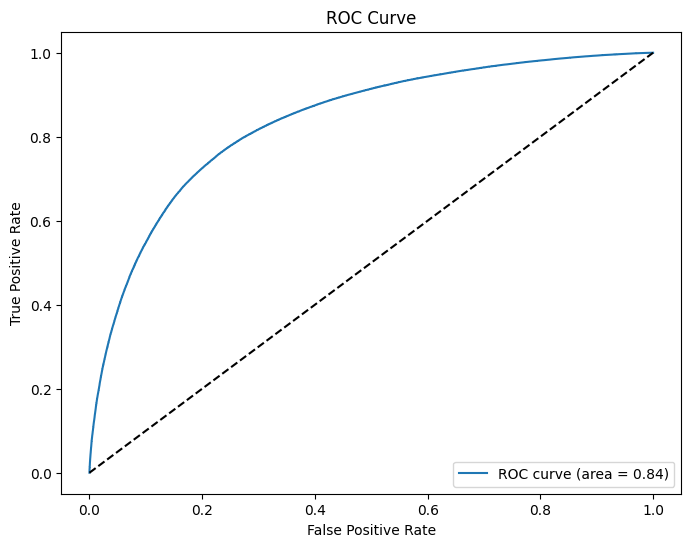

In [ ]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
import matplotlib.pyplot as plt
import pandas as pd

# Evaluate the AUC using the evaluator
evaluator = BinaryClassificationEvaluator(labelCol="target", rawPredictionCol="rawPrediction", metricName="areaUnderROC")
auc = evaluator.evaluate(logistic_predictions)
print(f"AUC: {auc}")

# Extract the probability and label columns
prob_labels = logistic_predictions.select("probability", "target")

# Convert to Pandas DataFrame for manual ROC computation
prob_labels_pd = prob_labels.toPandas()

# Extract the positive class probabilities
prob_labels_pd['probability'] = prob_labels_pd['probability'].apply(lambda x: x[1])

# Sort by probability in descending order
prob_labels_pd = prob_labels_pd.sort_values(by='probability', ascending=False)

# Calculate TPR and FPR
TPR = []
FPR = []
P = sum(prob_labels_pd['target'])
N = len(prob_labels_pd['target']) - P
tp = 0
fp = 0

for i in range(len(prob_labels_pd)):
    if prob_labels_pd.iloc[i]['target'] == 1:
        tp += 1
    else:
        fp += 1
    TPR.append(tp / P)
    FPR.append(fp / N)

# Plotting the ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(FPR, TPR, label=f'ROC curve (area = {auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line for random classifier
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()


In [ ]:
# 1. Define the Parameter Grid:
from pyspark.ml.tuning import ParamGridBuilder

param_grid = (ParamGridBuilder()
               .addGrid(lr.regParam, [0.01, 0.1])
               .addGrid(lr.elasticNetParam, [0.0, 0.5])
               .addGrid(lr.maxIter, [50, 100])
               .build())

In [ ]:
# 2. Set Up Cross-Validation:
from pyspark.ml.tuning import CrossValidator
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Initialize evaluator
evaluator = MulticlassClassificationEvaluator(
    labelCol="target", 
    predictionCol="prediction", 
    metricName="accuracy")

# Initialize CrossValidator
crossval = CrossValidator(
    estimator=lr,              # Base model
    estimatorParamMaps=param_grid,  # Parameter grid
    evaluator=evaluator,      # Evaluation metric
    numFolds=3                # Number of folds for cross-validation
)

In [ ]:
# 3. Fit the Cross-Validator:
# Fit the cross-validator to the training data
cv_model = crossval.fit(train_tfidf_df)

# Get the best model from cross-validation
best_model = cv_model.bestModel

print("Best Model:")
print(best_model)

# Make predictions on the test set
best_predictions = best_model.transform(test_tfidf_df)

Uploading artifacts:   0%|          | 0/4 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/4 [00:00<?, ?it/s]

Best Model:
LogisticRegressionModel: uid=LogisticRegression_1676770e03a1, numClasses=2, numFeatures=10000


Test set accuracy of best model = 0.7636996115391963


/databricks/spark/python/pyspark/sql/context.py:164: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


Best Model Confusion Matrix:
[[141592.  47968.]
 [ 41087. 146225.]]
Precision of best model: 0.7529880067767634
Recall of best model: 0.7806493977961904
F1-Score of best model: 0.7665692454882637
Specificity of best model: 0.7469508335091791
AUC of best model: 0.8367752022277231


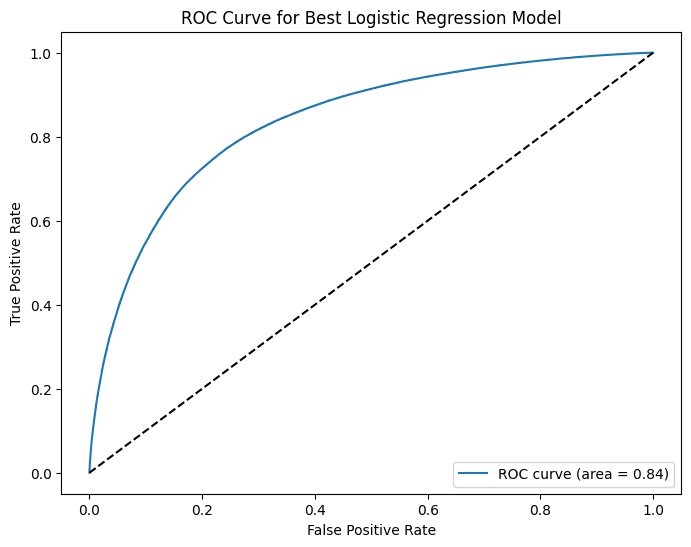

In [ ]:
# 4. Evaluate the best model
logistic_accuracy_best = evaluator.evaluate(best_predictions)
print(f"Test set accuracy of best model = {logistic_accuracy_best}")

# Confusion Matrix
best_metrics = MulticlassMetrics(best_predictions.select(col("prediction").cast("double"), col("target").cast("double")).rdd)
confusion_matrix_best = best_metrics.confusionMatrix().toArray()
print("Best Model Confusion Matrix:")
print(confusion_matrix_best)

# Precision
precision_best = best_metrics.precision(1.0)
print(f"Precision of best model: {precision_best}")

# Recall
recall_best = best_metrics.recall(1.0)
print(f"Recall of best model: {recall_best}")

# F1-Score
f1_score_best = best_metrics.fMeasure(1.0)
print(f"F1-Score of best model: {f1_score_best}")

# Specificity (For Binary Classification)
tn_best = confusion_matrix_best[0][0]
fp_best = confusion_matrix_best[0][1]
specificity_best = tn_best / (tn_best + fp_best)
print(f"Specificity of best model: {specificity_best}")

# ROC AUC
evaluator_auc = BinaryClassificationEvaluator(labelCol="target", rawPredictionCol="rawPrediction", metricName="areaUnderROC")
auc_best = evaluator_auc.evaluate(best_predictions)
print(f"AUC of best model: {auc_best}")

# ROC Curve
prob_labels_best = best_predictions.select("probability", "target")
prob_labels_pd_best = prob_labels_best.toPandas()
prob_labels_pd_best['probability'] = prob_labels_pd_best['probability'].apply(lambda x: x[1])
prob_labels_pd_best = prob_labels_pd_best.sort_values(by='probability', ascending=False)

# Calculate TPR and FPR
TPR_best = []
FPR_best = []
P_best = sum(prob_labels_pd_best['target'])
N_best = len(prob_labels_pd_best['target']) - P_best
tp_best = 0
fp_best = 0

for i in range(len(prob_labels_pd_best)):
    if prob_labels_pd_best.iloc[i]['target'] == 1:
        tp_best += 1
    else:
        fp_best += 1
    TPR_best.append(tp_best / P_best)
    FPR_best.append(fp_best / N_best)

# Plotting the ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(FPR_best, TPR_best, label=f'ROC curve (area = {auc_best:.2f})')
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line for random classifier
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Best Logistic Regression Model')
plt.legend(loc="lower right")
plt.show()

# Naive Bayes

In [ ]:
from pyspark.ml.classification import NaiveBayes
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

In [ ]:
# Initialize the Naive Bayes classifier
nb = NaiveBayes(featuresCol="features", labelCol="target")

In [ ]:
# Fit the model on the training data
nb_model = nb.fit(train_tfidf_df)

Uploading artifacts:   0%|          | 0/4 [00:00<?, ?it/s]

In [ ]:
# Make predictions on the test data
naive_predictions = nb_model.transform(test_tfidf_df)

In [ ]:
# Evaluate the model
evaluator = MulticlassClassificationEvaluator(labelCol="target", predictionCol="prediction", metricName="accuracy")
nb_accuracy = evaluator.evaluate(naive_predictions)
print(f"Accuracy of Naive Bayes model: {nb_accuracy:.2f}")

Accuracy of Naive Bayes model: 0.74


In [ ]:
# Show some predictions
naive_predictions.select("features", "target", "prediction", "probability").show()

+--------------------+------+----------+--------------------+
|            features|target|prediction|         probability|
+--------------------+------+----------+--------------------+
|(10000,[281,1528,...|     0|       0.0|[0.99996914006371...|
|(10000,[666,1379]...|     1|       1.0|[0.38235457667258...|
|(10000,[600,2977,...|     1|       1.0|[5.38749973531931...|
|(10000,[157,3704,...|     0|       1.0|[0.13072135826604...|
|(10000,[2306,5477...|     1|       0.0|[0.94678009108029...|
|(10000,[750,7293]...|     1|       1.0|[6.47697471122636...|
|(10000,[157,613,1...|     0|       0.0|[0.95160942790829...|
|(10000,[2366,6538...|     0|       0.0|[0.78625111571557...|
|(10000,[856,2997,...|     1|       1.0|[1.73508533436249...|
|(10000,[960,3482,...|     0|       1.0|[2.93026260850226...|
|(10000,[214,2069,...|     0|       0.0|[0.98474899599929...|
|(10000,[1523,9133...|     0|       0.0|[0.78169772361802...|
|(10000,[938,3834]...|     1|       1.0|[5.29506066734397...|
|(10000,

In [ ]:
# 1. Initialize the Naive Bayes Model:
from pyspark.ml.classification import NaiveBayes

# Initialize NaiveBayes
nb = NaiveBayes(featuresCol="features", labelCol="target")

In [ ]:
from pyspark.ml.tuning import ParamGridBuilder

# Define a smaller parameter grid
param_grid = (ParamGridBuilder()
               .addGrid(nb.smoothing, [0.1, 1.0])  # Reduced smoothing values
               .addGrid(nb.modelType, ['multinomial'])  # Only one model type
               .build())

In [ ]:
# 3. Set Up Cross-Validation:
from pyspark.ml.tuning import CrossValidator
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Initialize evaluator
evaluator = MulticlassClassificationEvaluator(
    labelCol="target", 
    predictionCol="prediction", 
    metricName="accuracy")

# Initialize CrossValidator
crossval = CrossValidator(
    estimator=nb,              # Base model
    estimatorParamMaps=param_grid,  # Parameter grid
    evaluator=evaluator,      # Evaluation metric
    numFolds=3                # Number of folds for cross-validation
)

In [ ]:
# 4. Fit the Cross-Validator:
# Fit the cross-validator to the training data
cv_model = crossval.fit(train_tfidf_df)

# Get the best model from cross-validation
best_model = cv_model.bestModel

print("Best Model:")
print(best_model)

Uploading artifacts:   0%|          | 0/4 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/4 [00:00<?, ?it/s]

Best Model:
NaiveBayesModel: uid=NaiveBayes_8ca2ed3d46d3, modelType=multinomial, numClasses=2, numFeatures=10000


Test set accuracy of best model = 0.7430188499012927


/databricks/spark/python/pyspark/sql/context.py:164: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


Best Model Confusion Matrix:
[[141379.  48181.]
 [ 48668. 138644.]]
Precision of best model: 0.7421062491636559
Recall of best model: 0.7401768172888016
F1-Score of best model: 0.7411402774919348
Specificity of best model: 0.7458271787296898
AUC of best model: 0.5239722216438052


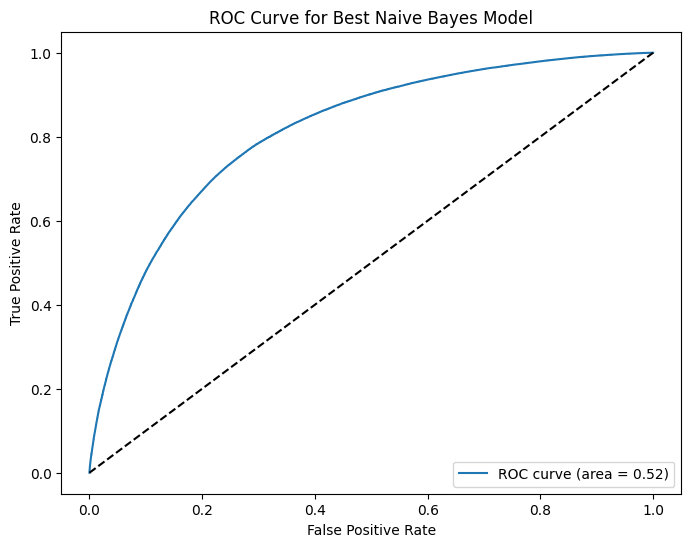

In [ ]:
# 5. Evaluate the Best Model:
# Make predictions on the test set
best_predictions = best_model.transform(test_tfidf_df)

# Evaluate the best model
nb_accuracy_best = evaluator.evaluate(best_predictions)
print(f"Test set accuracy of best model = {nb_accuracy_best}")

from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.sql.functions import col

# Confusion Matrix
best_metrics = MulticlassMetrics(best_predictions.select(col("prediction").cast("double"), col("target").cast("double")).rdd)
confusion_matrix_best = best_metrics.confusionMatrix().toArray()
print("Best Model Confusion Matrix:")
print(confusion_matrix_best)

# Precision
precision_best = best_metrics.precision(1.0)
print(f"Precision of best model: {precision_best}")

# Recall
recall_best = best_metrics.recall(1.0)
print(f"Recall of best model: {recall_best}")

# F1-Score
f1_score_best = best_metrics.fMeasure(1.0)
print(f"F1-Score of best model: {f1_score_best}")

# Specificity (For Binary Classification)
tn_best = confusion_matrix_best[0][0]
fp_best = confusion_matrix_best[0][1]
specificity_best = tn_best / (tn_best + fp_best)
print(f"Specificity of best model: {specificity_best}")

# ROC AUC
from pyspark.ml.evaluation import BinaryClassificationEvaluator
import pandas as pd
import matplotlib.pyplot as plt

evaluator_auc = BinaryClassificationEvaluator(labelCol="target", rawPredictionCol="rawPrediction", metricName="areaUnderROC")
auc_best = evaluator_auc.evaluate(best_predictions)
print(f"AUC of best model: {auc_best}")

# ROC Curve
prob_labels_best = best_predictions.select("probability", "target")
prob_labels_pd_best = prob_labels_best.toPandas()
prob_labels_pd_best['probability'] = prob_labels_pd_best['probability'].apply(lambda x: x[1])
prob_labels_pd_best = prob_labels_pd_best.sort_values(by='probability', ascending=False)

# Calculate TPR and FPR
TPR_best = []
FPR_best = []
P_best = sum(prob_labels_pd_best['target'])
N_best = len(prob_labels_pd_best['target']) - P_best
tp_best = 0
fp_best = 0

for i in range(len(prob_labels_pd_best)):
    if prob_labels_pd_best.iloc[i]['target'] == 1:
        tp_best += 1
    else:
        fp_best += 1
    TPR_best.append(tp_best / P_best)
    FPR_best.append(fp_best / N_best)

# Plotting the ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(FPR_best, TPR_best, label=f'ROC curve (area = {auc_best:.2f})')
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line for random classifier
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Best Naive Bayes Model')
plt.legend(loc="lower right")
plt.show()

# Decision Tree

In [ ]:
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

In [ ]:
# Step 3: Initialize the Decision Tree Classifier
dt = DecisionTreeClassifier(featuresCol="features",labelCol="target")

In [ ]:
# Step 4: Fit the model on the training data
dt_model = dt.fit(train_tfidf_df)

Exception ignored in: <function JavaModelWrapper.__del__ at 0x7f2e26cc8860>
Traceback (most recent call last):
  File "/databricks/spark/python/pyspark/mllib/common.py", line 152, in __del__
    assert self._sc._gateway is not None
           ^^^^^^^^
AttributeError: 'BinaryClassificationMetrics' object has no attribute '_sc'


Uploading artifacts:   0%|          | 0/4 [00:00<?, ?it/s]

In [ ]:
# Step 5: Make predictions on the test data
predictions = dt_model.transform(test_tfidf_df)

In [ ]:
evaluator = MulticlassClassificationEvaluator(labelCol="target", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)

In [ ]:
print(f"Test Accuracy: {accuracy:.2f}")

Test Accuracy: 0.55


In [ ]:
# Optional: Show the predictions
predictions.select("target", "prediction").show(truncate=False)

+------+----------+
|target|prediction|
+------+----------+
|0     |1.0       |
|1     |1.0       |
|1     |1.0       |
|0     |1.0       |
|1     |1.0       |
|1     |1.0       |
|0     |1.0       |
|0     |1.0       |
|1     |1.0       |
|0     |0.0       |
|0     |1.0       |
|0     |1.0       |
|1     |1.0       |
|0     |1.0       |
|0     |1.0       |
|0     |1.0       |
|1     |1.0       |
|0     |0.0       |
|0     |1.0       |
|0     |1.0       |
+------+----------+
only showing top 20 rows



# Random Forest

In [ ]:
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

In [ ]:
# Step 1: Initialize the Random Forest Classifier
rf = RandomForestClassifier(labelCol="target", featuresCol="features", numTrees=10)

In [ ]:
# Step 2: Fit the model on the training data
rf_model = rf.fit(train_tfidf_df)

Uploading artifacts:   0%|          | 0/4 [00:00<?, ?it/s]

In [ ]:
# Step 3: Make predictions on the test data
predictions = rf_model.transform(test_tfidf_df)

In [ ]:
# Step 4: Evaluate the model
evaluator = MulticlassClassificationEvaluator(labelCol="target", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)

In [ ]:
print(f"Test Accuracy: {accuracy:.2f}")

Test Accuracy: 0.55


In [ ]:
# Optional: Show the predictions
predictions.select("features", "target", "prediction").show(truncate=False)

+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+------+----------+
|features                                                                                                                                                                                                                                                               |target|prediction|
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+------+----------+
|(10000,[281,1528,4319,9257],[4.454584297541965,6.892655105649432,3.9492870147240824,3.9338014624808064])                                           

In [ ]:
# 1. Initialize the Random Forest Model:
from pyspark.ml.classification import RandomForestClassifier

# Initialize RandomForestClassifier
rf = RandomForestClassifier(featuresCol="features", labelCol="target")

In [ ]:
# 2. Define the Parameter Grid:
from pyspark.ml.tuning import ParamGridBuilder

# Define a smaller parameter grid
param_grid = (ParamGridBuilder()
               .addGrid(rf.numTrees, [10, 30])  # Reduced number of trees
               .addGrid(rf.maxDepth, [5, 10])    # Reduced depth
               .addGrid(rf.maxBins, [16, 32])    # Reduced number of bins
               .build())


In [ ]:
# 3. Set Up Cross-Validation:
from pyspark.ml.tuning import CrossValidator
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Initialize evaluator
evaluator = MulticlassClassificationEvaluator(
    labelCol="target", 
    predictionCol="prediction", 
    metricName="accuracy")

# Initialize CrossValidator with reduced number of folds
crossval = CrossValidator(
    estimator=rf,              # Base model
    estimatorParamMaps=param_grid,  # Parameter grid
    evaluator=evaluator,      # Evaluation metric
    numFolds=3                # Reduced number of folds for faster computation
)

In [ ]:
# 4. Fit the Cross-Validator:
# Fit the cross-validator to the training data
cv_model = crossval.fit(train_tfidf_df)

# Get the best model from cross-validation
best_model = cv_model.bestModel

print("Best Model:")
print(best_model)

com.databricks.backend.common.rpc.CommandCancelledException
	at com.databricks.spark.chauffeur.SequenceExecutionState.$anonfun$cancel$5(SequenceExecutionState.scala:136)
	at scala.Option.getOrElse(Option.scala:189)
	at com.databricks.spark.chauffeur.SequenceExecutionState.$anonfun$cancel$3(SequenceExecutionState.scala:136)
	at com.databricks.spark.chauffeur.SequenceExecutionState.$anonfun$cancel$3$adapted(SequenceExecutionState.scala:133)
	at scala.collection.immutable.Range.foreach(Range.scala:158)
	at com.databricks.spark.chauffeur.SequenceExecutionState.cancel(SequenceExecutionState.scala:133)
	at com.databricks.spark.chauffeur.ExecContextState.cancelRunningSequence(ExecContextState.scala:729)
	at com.databricks.spark.chauffeur.ExecContextState.$anonfun$cancel$1(ExecContextState.scala:447)
	at scala.Option.getOrElse(Option.scala:189)
	at com.databricks.spark.chauffeur.ExecContextState.cancel(ExecContextState.scala:447)
	at com.databricks.spark.chauffeur.ChauffeurState.cancelExecutio

In [ ]:
# 5. Evaluate the Best Model:
# Make predictions on the test set
best_predictions = best_model.transform(test_tfidf_df)

# Evaluate the best model
rf_accuracy_best = evaluator.evaluate(best_predictions)
print(f"Test set accuracy of best model = {rf_accuracy_best}")

from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.sql.functions import col

# Confusion Matrix
best_metrics = MulticlassMetrics(best_predictions.select(col("prediction").cast("double"), col("target").cast("double")).rdd)
confusion_matrix_best = best_metrics.confusionMatrix().toArray()
print("Best Model Confusion Matrix:")
print(confusion_matrix_best)

# Precision
precision_best = best_metrics.precision(1.0)
print(f"Precision of best model: {precision_best}")

# Recall
recall_best = best_metrics.recall(1.0)
print(f"Recall of best model: {recall_best}")

# F1-Score
f1_score_best = best_metrics.fMeasure(1.0)
print(f"F1-Score of best model: {f1_score_best}")

# Specificity (For Binary Classification)
tn_best = confusion_matrix_best[0][0]
fp_best = confusion_matrix_best[0][1]
specificity_best = tn_best / (tn_best + fp_best)
print(f"Specificity of best model: {specificity_best}")

# ROC AUC
from pyspark.ml.evaluation import BinaryClassificationEvaluator
import pandas as pd
import matplotlib.pyplot as plt

evaluator_auc = BinaryClassificationEvaluator(labelCol="target", rawPredictionCol="rawPrediction", metricName="areaUnderROC")
auc_best = evaluator_auc.evaluate(best_predictions)
print(f"AUC of best model: {auc_best}")

# ROC Curve
prob_labels_best = best_predictions.select("probability", "target")
prob_labels_pd_best = prob_labels_best.toPandas()
prob_labels_pd_best['probability'] = prob_labels_pd_best['probability'].apply(lambda x: x[1])
prob_labels_pd_best = prob_labels_pd_best.sort_values(by='probability', ascending=False)

# Calculate TPR and FPR
TPR_best = []
FPR_best = []
P_best = sum(prob_labels_pd_best['target'])
N_best = len(prob_labels_pd_best['target']) - P_best
tp_best = 0
fp_best = 0

for i in range(len(prob_labels_pd_best)):
    if prob_labels_pd_best.iloc[i]['target'] == 1:
        tp_best += 1
    else:
        fp_best += 1
    TPR_best.append(tp_best / P_best)
    FPR_best.append(fp_best / N_best)

# Plotting the ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(FPR_best, TPR_best, label=f'ROC curve (area = {auc_best:.2f})')
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line for random classifier
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Best Random Forest Model')
plt.legend(loc="lower right")
plt.show()

# SVM

In [ ]:
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.classification import LinearSVC

In [ ]:
# Initialize SVM Classifier
svm = LinearSVC(labelCol="target", featuresCol="features", maxIter=100)

In [ ]:
# Train the model
svm_model = svm.fit(train_tfidf_df)

Uploading artifacts:   0%|          | 0/4 [00:00<?, ?it/s]

In [ ]:
# Make predictions
predictions = svm_model.transform(test_tfidf_df)

In [ ]:
# Evaluate the model
evaluator = MulticlassClassificationEvaluator(labelCol="target", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print(f"Test Accuracy = {accuracy}")

Test Accuracy = 0.7636093952323335
